# What is the notebook about?

## Problem - Taxi Environment Algorithms
This problem deals with a taxi environment and stochastic actions. The tasks you have to do are:
- Implement Policy Iteration
- Implement Modified Policy Iteration
- Implement Value Iteration
- Implement Gauss Seidel Value Iteration
- Visualize the results
- Explain the results

## How to use this notebook? 📝

- This is a shared template and any edits you make here will not be saved.**You
should make a copy in your own drive**. Click the "File" menu (top-left), then "Save a Copy in Drive". You will be working in your copy however you like.

- **Update the config parameters**. You can define the common variables here

Variable | Description
--- | ---
`AICROWD_DATASET_PATH` | Path to the file containing test data. This should be an absolute path.
`AICROWD_RESULTS_DIR` | Path to write the output to.
`AICROWD_ASSETS_DIR` | In case your notebook needs additional files (like model weights, etc.,), you can add them to a directory and specify the path to the directory here (please specify relative path). The contents of this directory will be sent to AIcrowd for evaluation.
`AICROWD_API_KEY` | In order to submit your code to AIcrowd, you need to provide your account's API key. This key is available at https://www.aicrowd.com/participants/me

- **Installing packages**. Please use the [Install packages 🗃](#install-packages-) section to install the packages

# Setup AIcrowd Utilities 🛠

We use this to bundle the files for submission and create a submission on AIcrowd. Do not edit this block.

In [61]:
!pip install aicrowd-cli > /dev/null 

# AIcrowd Runtime Configuration 🧷

Get login API key from https://www.aicrowd.com/participants/me

In [62]:
import os

AICROWD_DATASET_PATH = os.getenv("DATASET_PATH", os.getcwd()+"/13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip")
AICROWD_RESULTS_DIR = os.getenv("OUTPUTS_DIR", "results")


API Key valid
Saved API Key successfully!
13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip: 100% 31.2k/31.2k [00:00<00:00, 125kB/s]


In [64]:
!unzip $AICROWD_DATASET_PATH

Archive:  /content/13d77bb0-b325-4e95-a03b-833eb6694acd_a2_taxi_inputs.zip
   creating: inputs/
  inflating: inputs/inputs_base.npy  
  inflating: inputs/inputs_1.npy     
  inflating: inputs/inputs_0.npy     
  inflating: inputs/inputs_2.npy     
   creating: targets/
  inflating: targets/targets_2.npy   
  inflating: targets/targets_0.npy   
  inflating: targets/targets_1.npy   
  inflating: targets/targets_base.npy  


In [65]:
DATASET_DIR = 'inputs/'

## Taxi Environment

Read the environment to understand the functions, but do not edit anything

In [66]:
import numpy as np
from copy import deepcopy
import pandas as pd
class TaxiEnv_HW2:
    def __init__(self, states, actions, probabilities, rewards, initial_policy):
        self.possible_states = states
        self._possible_actions = {st: ac for st, ac in zip(states, actions)}
        self._ride_probabilities = {st: pr for st, pr in zip(states, probabilities)}
        self._ride_rewards = {st: rw for st, rw in zip(states, rewards)}
        self.initial_policy = initial_policy
        self._verify()

    def _check_state(self, state):
        assert state in self.possible_states, "State %s is not a valid state" % state

    def _verify(self):
        """ 
        Verify that data conditions are met:
        Number of actions matches shape of next state and actions
        Every probability distribution adds up to 1 
        """
        ns = len(self.possible_states)
        for state in self.possible_states:
            ac = self._possible_actions[state]
            na = len(ac)

            rp = self._ride_probabilities[state]
            assert np.all(rp.shape == (na, ns)), "Probabilities shape mismatch"
        
            rr = self._ride_rewards[state]
            assert np.all(rr.shape == (na, ns)), "Rewards shape mismatch"

            assert np.allclose(rp.sum(axis=1), 1), "Probabilities don't add up to 1"

    def possible_actions(self, state):
        """ Return all possible actions from a given state """
        self._check_state(state)
        return self._possible_actions[state]

    def ride_probabilities(self, state, action):
        """ 
        Returns all possible ride probabilities from a state for a given action
        For every action a list with the returned with values in the same order as self.possible_states
        """
        actions = self.possible_actions(state)
        ac_idx = actions.index(action)
        return self._ride_probabilities[state][ac_idx]

    def ride_rewards(self, state, action):
        actions = self.possible_actions(state)
        ac_idx = actions.index(action)
        return self._ride_rewards[state][ac_idx]

## Example of Environment usage

In [67]:
def check_taxienv():
    # These are the values as used in the pdf, but they may be changed during submission, so do not hardcode anything

    states = ['A', 'B', 'C']

    actions = [['1','2','3'], ['1','2'], ['1','2','3']]

    probs = [np.array([[1/2,  1/4,  1/4],
                    [1/16, 3/4,  3/16],
                    [1/4,  1/8,  5/8]]),

            np.array([[1/2,   0,     1/2],
                    [1/16,  7/8,  1/16]]),

            np.array([[1/4,  1/4,  1/2],
                    [1/8,  3/4,  1/8],
                    [3/4,  1/16, 3/16]]),]

    rewards = [np.array([[10,  4,  8],
                        [ 8,  2,  4],
                        [ 4,  6,  4]]),

            np.array([[14,  0, 18],
                        [ 8, 16,  8]]),

            np.array([[10,  2,  8],
                        [6,   4,  2],
                        [4,   0,  8]]),]
    initial_policy = {'A': '1', 'B': '1', 'C': '1'}

    env = TaxiEnv_HW2(states, actions, probs, rewards, initial_policy)
    print("All possible states", env.possible_states)
    print("All possible actions from state B", env.possible_actions('B'))
    print("Ride probabilities from state A with action 2", env.ride_probabilities('A', '2'))
    print("Ride rewards from state C with action 3", env.ride_rewards('C', '3'))

    base_kwargs = {"states": states, "actions": actions, 
                "probabilities": probs, "rewards": rewards,
                "initial_policy": initial_policy}
    return base_kwargs

base_kwargs = check_taxienv()
env = TaxiEnv_HW2(**base_kwargs)

All possible states ['A', 'B', 'C']
All possible actions from state B ['1', '2']
Ride probabilities from state A with action 2 [0.0625 0.75   0.1875]
Ride rewards from state C with action 3 [4 0 8]


## Task 1 - Policy Iteration
Run policy iteration on the environment and generate the policy and expected reward

In [68]:
# 1.1 Policy Iteration
def policy_iteration(taxienv, gamma):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    ride_probabilities = taxienv.ride_probabilities
    ride_rewards =taxienv.ride_rewards
    actions = taxienv._possible_actions
    done = 0
    tol = 1e-8
    ite1 = 0
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {}
    extra_info[0] = [deepcopy(values),deepcopy(policy)]
    while done == 0:
      ite1 += 1
      ite2 = 0
      delta = 0
      #Policy Evaluation
      while delta > 1e-8 or ite2 == 0:
        ite2 += 1
        delta = 0
        values_old = deepcopy(values)
        for st1 in states:
          act = policy[st1]
          values[st1] = 0
          for st2 in states:
            values[st1] +=  ride_probabilities(st1,act)[states.index(st2)]*(ride_rewards(st1,act)[states.index(st2)] + gamma*values_old[st2])
          delta = max(delta,abs(values[st1]-values_old[st1]))
      
      #Policy Improvement
      done = 1
      policy_old = deepcopy(policy)
      for st1 in states:
        J_vals = []
        act_old = policy_old[st1]
        for a in actions[st1]:
          J = 0
          for st2 in states:
            J += ride_probabilities(st1,a)[states.index(st2)]*(ride_rewards(st1,a)[states.index(st2)] + gamma*values[st2])
          J_vals.append(J)
        new_act = actions[st1][J_vals.index(max(J_vals))]
        if act_old != new_act:
          done = 0
        policy[st1] = new_act
      extra_info[ite1] = [deepcopy(values),deepcopy(policy)]
    ## Do not edit below this line
    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

#### Policy Iteration with $\gamma=0.9$

In [69]:
gamma = 0.9
results, extra_info = policy_iteration(env, gamma)
print("Expected Reward")
print(results["Expected Reward"])
print()
print("Optimal Policy")
print(results["Policy"])

Expected Reward
{'A': 121.65347103938102, 'B': 135.3062754397477, 'C': 122.83690299204375}

Optimal Policy
{'A': '2', 'B': '2', 'C': '2'}


# Task 2 - Policy Iteration for multiple values of gamma

Ideally this code should run as is

In [70]:
# 1.2 Policy Iteration with different values of gamma
def run_policy_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = policy_iteration(env, gamma)
    return results, extra_info

results, extra_info = run_policy_iteration(env)

In [71]:
#Printing Results
print("Expected Reward and Optimal Policy after Policy Iteration with multiple values of gamma")
pd.set_option('display.max_colwidth', None)
pd.DataFrame(results).T

Expected Reward and Optimal Policy after Policy Iteration with multiple values of gamma


Expected Reward                          Policy
0.05    {'A': 8.511527294182539, 'B': 16.400259908653545, 'C': 7.498869066334438}  {'A': '1', 'B': '1', 'C': '1'}
0.10    {'A': 9.076506148654659, 'B': 16.856368562663413, 'C': 8.050865123013633}  {'A': '1', 'B': '1', 'C': '1'}
0.15      {'A': 9.708121492773689, 'B': 17.46450304225433, 'C': 8.66916045381265}  {'A': '1', 'B': '2', 'C': '1'}
0.20      {'A': 10.437030073770368, 'B': 18.482142855718322, 'C': 9.384398494823}  {'A': '1', 'B': '2', 'C': '1'}
0.25   {'A': 11.274074071593612, 'B': 19.62962962714457, 'C': 10.207407404926943}  {'A': '1', 'B': '2', 'C': '1'}
0.30   {'A': 12.243837242514767, 'B': 20.93406593274288, 'C': 11.162756161433684}  {'A': '1', 'B': '2', 'C': '1'}
0.35   {'A': 13.37871443314124, 'B': 22.430769227661276, 'C': 12.282824022182337}  {'A': '1', 'B': '2', 'C': '1'}
0.40   {'A': 14.722222218890456, 'B': 24.16666666333477, 'C': 13.611111107779344}  {'A': '1', 'B': '2', 'C': '1'}
0.45    {'A': 16.334131264623938, 'B': 26.2055335916294, 'C': 15.207370701243658}  {'A': '1', 'B': '2', 'C': '1'}
0.50  {'A': 18.298701292975394, 'B': 28.636363630637724, 'C': 17.155844150118252}  {'A': '1', 'B': '2', 'C': '1'}
0.55  {'A': 20.789988631690285, 'B': 31.607396693357217, 'C': 19.830725208961304}  {'A': '1', 'B': '2', 'C': '2'}
0.60   {'A': 24.025686435735523, 'B': 35.32772363679841, 'C': 23.458813096497263}  {'A': '1', 'B': '2', 'C': '2'}
0.65     {'A': 28.276692058262245, 'B': 40.0962805733634, 'C': 28.12997877956433}  {'A': '1', 'B': '2', 'C': '2'}
0.70    {'A': 34.06193076352557, 'B': 46.435416151978885, 'C': 34.36604100348755}  {'A': '1', 'B': '2', 'C': '2'}
0.75    {'A': 42.31741137421433, 'B': 55.285053901178884, 'C': 43.10631738345932}  {'A': '1', 'B': '2', 'C': '2'}
0.80     {'A': 55.0793650415215, 'B': 68.55820102035747, 'C': 56.269841231997695}  {'A': '2', 'B': '2', 'C': '2'}
0.85     {'A': 77.24651208813728, 'B': 90.81170060881541, 'C': 78.43345570831532}  {'A': '2', 'B': '2', 'C': '2'}
0.90   {'A': 121.65347103938102, 'B': 135.3062754397477, 'C': 122.83690299204375}  {'A': '2', 'B': '2', 'C': '2'}
0.95   {'A': 255.0229082403122, 'B': 268.76461831792886, 'C': 256.20284924326205}  {'A': '2', 'B': '2', 'C': '2'}

# Task 3 - Modifed Policy Iteration

Implement modified policy iteration (where Value iteration is done for fixed m number of steps)

In [72]:
# 1.3 Modified Policy Iteration
def modified_policy_iteration(taxienv, gamma, m):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    ride_probabilities = taxienv.ride_probabilities
    ride_rewards =taxienv.ride_rewards
    actions = taxienv._possible_actions
    done = 0
    tol = 1e-8
    ite1 = 0
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {}
    extra_info[0] = [deepcopy(values),deepcopy(policy)]
    while done == 0:
      ite1 += 1
      ite2 = 0
      # delta = 0
      #Policy Evaluation
      for _ in range(m):
        # while delta > 1e-8 or ite2 == 0:
        # ite2 += 1
        # delta = 0
        values_old = deepcopy(values)
        for st1 in states:
          act = policy[st1]
          values[st1] = 0
          for st2 in states:
            values[st1] +=  ride_probabilities(st1,act)[states.index(st2)]*(ride_rewards(st1,act)[states.index(st2)] + gamma*values_old[st2])
          # delta = max(delta,abs(values[st1]-values_old[st1]))
        
      #Policy Improvement
      done = 1
      policy_old = deepcopy(policy)
      for st1 in states:
        J_vals = []
        act_old = policy_old[st1]
        for a in actions[st1]:
          J = 0
          for st2 in states:
            J += ride_probabilities(st1,a)[states.index(st2)]*(ride_rewards(st1,a)[states.index(st2)] + gamma*values[st2])
          J_vals.append(J)
        new_act = actions[st1][J_vals.index(max(J_vals))]
        if act_old != new_act:
          done = 0
        policy[st1] = new_act
      extra_info[ite1] = [deepcopy(values),deepcopy(policy)]
    ## Do not edit below this line


    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

#### Policy Iteration with $\gamma=0.9$ and $m=5$

In [73]:
gamma = 0.9; m = 5
results, extra_info = modified_policy_iteration(env, gamma, m)
print("Expected Reward")
print(results["Expected Reward"])
print()
print("Optimal Policy")
print(results["Policy"])

Expected Reward
{'A': 89.81178760453517, 'B': 103.46459982778873, 'C': 90.99521888644551}

Optimal Policy
{'A': '2', 'B': '2', 'C': '2'}


# Task 4 Modified policy iteration for multiple values of m

Ideally this code should run as is

In [74]:
def run_modified_policy_iteration(env):
    m_values = np.arange(1, 15)
    gamma = 0.9
    results, extra_info = {}, {}
    for m in m_values:
        results[m], extra_info[m] = modified_policy_iteration(env, gamma, m)
    return results, extra_info

results, extra_info = run_modified_policy_iteration(env)

In [75]:
#Printing Results
print("Expected Reward and Optimal Policy after Modified Policy Iteration with multiple values of m")
pd.set_option('display.max_colwidth', None)
pd.DataFrame(results).T

Expected Reward and Optimal Policy after Modified Policy Iteration with multiple values of m


Expected Reward                          Policy
1                  {'A': 25.675390625, 'B': 39.27046874999999, 'C': 26.9415625}  {'A': '2', 'B': '2', 'C': '2'}
2    {'A': 48.55490468521119, 'B': 62.203121287078865, 'C': 49.737400154724135}  {'A': '2', 'B': '2', 'C': '2'}
3       {'A': 66.5070336319201, 'B': 80.16002669080505, 'C': 67.69034691854696}  {'A': '2', 'B': '2', 'C': '2'}
4      {'A': 79.80001035898594, 'B': 93.45288211402925, 'C': 80.98345265619488}  {'A': '2', 'B': '2', 'C': '2'}
5     {'A': 89.81178760453517, 'B': 103.46459982778873, 'C': 90.99521888644551}  {'A': '2', 'B': '2', 'C': '2'}
6       {'A': 97.34789594613352, 'B': 111.0007013724186, 'C': 98.5313279386138}  {'A': '2', 'B': '2', 'C': '2'}
7   {'A': 103.04102709136063, 'B': 116.69383160589359, 'C': 104.22445904173425}  {'A': '2', 'B': '2', 'C': '2'}
8   {'A': 107.35314857748017, 'B': 121.00595299110296, 'C': 108.53658053027281}  {'A': '2', 'B': '2', 'C': '2'}
9   {'A': 110.62884446690502, 'B': 124.28164886875567, 'C': 111.81227641956042}  {'A': '2', 'B': '2', 'C': '2'}
10   {'A': 113.12458909097927, 'B': 126.77739349151406, 'C': 114.3080210436424}  {'A': '2', 'B': '2', 'C': '2'}
11   {'A': 115.03191631274339, 'B': 128.68472071312897, 'C': 116.2153482654061}  {'A': '2', 'B': '2', 'C': '2'}
12    {'A': 116.49414072619648, 'B': 130.1469451265653, 'C': 117.6775726788592}  {'A': '2', 'B': '2', 'C': '2'}
13  {'A': 117.61874705064764, 'B': 131.27155145101457, 'C': 118.80217900331036}  {'A': '2', 'B': '2', 'C': '2'}
14  {'A': 118.48653594228573, 'B': 132.13934034265242, 'C': 119.66996789494846}  {'A': '2', 'B': '2', 'C': '2'}

# Task 5 Value Iteration

Implement value iteration and find the policy and expected rewards

In [76]:
# 1.4 Value Iteration
def value_iteration(taxienv, gamma):
    # A list of all the states
    states = taxienv.possible_states
    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    ## Begin code here

    # Hints - 
    # Do not hardcode anything
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf


    # Put your extra information needed for plots etc in this dictionary
    extra_info = {}
    ride_probabilities = taxienv.ride_probabilities
    ride_rewards =taxienv.ride_rewards
    actions = taxienv._possible_actions
    tol = 1e-8
    ite = 0
    delta = 0
    ite = 0
    extra_info = {}
    extra_info[0] = [deepcopy(values),deepcopy(policy)]
    while delta>tol or ite==0:
      delta = 0
      ite += 1
      values_old = deepcopy(values)
      for st1 in states:
        MAX = -np.inf
        for a in actions[st1]:
          values[st1] = 0
          for st2 in states:
            values[st1] += ride_probabilities(st1,a)[states.index(st2)]*(ride_rewards(st1,a)[states.index(st2)] + gamma*values_old[st2])
          if values[st1] > MAX:
            MAX = deepcopy(values[st1])
            policy[st1] = a
        values[st1] = MAX
        delta = max(delta,abs(values[st1]-values_old[st1]))
          
      extra_info[ite] = [deepcopy(values),deepcopy(policy)]
    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

#### Value Iteration with $\gamma=0.9$

In [77]:
gamma = 0.9
results, extra_info = value_iteration(env, gamma)
print("Expected Reward")
print(results["Expected Reward"])
print()
print("Optimal Policy")
print(results["Policy"])

Expected Reward
{'A': 121.65347103895924, 'B': 135.30627543932593, 'C': 122.83690299162194}

Optimal Policy
{'A': '2', 'B': '2', 'C': '2'}


# Task 6 Value Iteration with multiple values of gamma

Ideally this code should run as is

In [78]:
def run_value_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results = {}
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = value_iteration(env, gamma)
    return results, extra_info
  
results, extra_info = run_value_iteration(env)

In [79]:
#Printing Results
print("Expected Reward and Optimal Policy after Value Iteration with multiple values of gamma")
pd.set_option('display.max_colwidth', None)
pd.DataFrame(results).T

Expected Reward and Optimal Policy after Value Iteration with multiple values of gamma


Expected Reward                          Policy
0.05    {'A': 8.511527294182539, 'B': 16.400259908653545, 'C': 7.498869066334438}  {'A': '1', 'B': '1', 'C': '1'}
0.10    {'A': 9.076506148654659, 'B': 16.856368562663413, 'C': 8.050865123013633}  {'A': '1', 'B': '1', 'C': '1'}
0.15     {'A': 9.708121491779233, 'B': 17.46450304126533, 'C': 8.669160452818193}  {'A': '1', 'B': '2', 'C': '1'}
0.20    {'A': 10.43703007317419, 'B': 18.482142855128945, 'C': 9.384398494226822}  {'A': '1', 'B': '2', 'C': '1'}
0.25  {'A': 11.274074070814656, 'B': 19.629629626369894, 'C': 10.207407404147988}  {'A': '1', 'B': '2', 'C': '1'}
0.30  {'A': 12.243837242020097, 'B': 20.934065932248725, 'C': 11.162756160939015}  {'A': '1', 'B': '2', 'C': '1'}
0.35   {'A': 13.378714431634197, 'B': 22.43076922615468, 'C': 12.282824020675294}  {'A': '1', 'B': '2', 'C': '1'}
0.40   {'A': 14.722222216827301, 'B': 24.16666666127172, 'C': 13.611111105716189}  {'A': '1', 'B': '2', 'C': '1'}
0.45    {'A': 16.33413126569031, 'B': 26.20553359269582, 'C': 15.207370702310026}  {'A': '1', 'B': '2', 'C': '1'}
0.50   {'A': 18.298701293190973, 'B': 28.636363630853307, 'C': 17.15584415033383}  {'A': '1', 'B': '2', 'C': '1'}
0.55  {'A': 20.789988627490125, 'B': 31.607396689157056, 'C': 19.830725204761144}  {'A': '1', 'B': '2', 'C': '2'}
0.60    {'A': 24.02568643325821, 'B': 35.327723634321096, 'C': 23.45881309401995}  {'A': '1', 'B': '2', 'C': '2'}
0.65    {'A': 28.276692058162972, 'B': 40.09628057326413, 'C': 28.12997877946505}  {'A': '1', 'B': '2', 'C': '2'}
0.70     {'A': 34.06193076174113, 'B': 46.43541615019445, 'C': 34.36604100170312}  {'A': '1', 'B': '2', 'C': '2'}
0.75   {'A': 42.317411373067756, 'B': 55.28505390003232, 'C': 43.106317382312746}  {'A': '1', 'B': '2', 'C': '2'}
0.80     {'A': 55.07936504724612, 'B': 68.55820102608209, 'C': 56.26984123772232}  {'A': '2', 'B': '2', 'C': '2'}
0.85     {'A': 77.24651209325512, 'B': 90.81170061393325, 'C': 78.43345571343316}  {'A': '2', 'B': '2', 'C': '2'}
0.90  {'A': 121.65347103895924, 'B': 135.30627543932593, 'C': 122.83690299162194}  {'A': '2', 'B': '2', 'C': '2'}
0.95   {'A': 255.02290824365164, 'B': 268.76461832126836, 'C': 256.2028492466015}  {'A': '2', 'B': '2', 'C': '2'}

# Task 7 Gauss Seidel Value Iteration

Implement Gauss Seidel Value Iteration

In [80]:
# 1.4 Gauss Seidel Value Iteration
def gauss_seidel_value_iteration(taxienv, gamma):
    # A list of all the states
    # For Gauss Seidel Value Iteration - iterate through the values in the same order
    states = taxienv.possible_states

    # Initial values
    values = {s: 0 for s in states}

    # This is a dictionary of states to policies -> e.g {'A': '1', 'B': '2', 'C': '1'}
    policy = taxienv.initial_policy.copy()

    # Hints - 
    # Do not hardcode anything
    # For Gauss Seidel Value Iteration - iterate through the values in the same order as taxienv.possible_states
    # Only the final result is required for the results
    # Put any extra data in "extra_info" dictonary for any plots etc
    # Use the helper functions taxienv.ride_rewards, taxienv.ride_probabilities,  taxienv.possible_actions
    # For terminating condition use the condition exactly mentioned in the pdf

    ## Begin code here
    
    # Put your extra information needed for plots etc in this dictionary
    extra_info = {}
    ride_probabilities = taxienv.ride_probabilities
    ride_rewards =taxienv.ride_rewards
    actions = taxienv._possible_actions
    tol = 1e-8
    ite = 0
    delta = 0
    ite = 0
    extra_info = {}
    extra_info[0] = [deepcopy(values),deepcopy(policy)]
    while delta>tol or ite==0:
      delta = 0
      ite += 1
      values_old = deepcopy(values)
      for st1 in states:
        MAX = -np.inf
        for a in actions[st1]:
          tmp = 0
          for st2 in states:
            tmp += ride_probabilities(st1,a)[states.index(st2)]*(ride_rewards(st1,a)[states.index(st2)] + gamma*values[st2])
          # values[st1] = tmp
          
          if tmp > MAX:
            MAX = tmp
            policy[st1] = a
        values[st1] = MAX
        delta = max(delta,abs(values[st1]-values_old[st1]))
          
      extra_info[ite] = [deepcopy(values),deepcopy(policy)]

    ## Do not edit below this line

    # Final results
    return {"Expected Reward": values, "Policy": policy}, extra_info

#### Gauss-Seidel Value Iteration with $\gamma=0.9$

In [81]:
gamma = 0.9
results, extra_info = gauss_seidel_value_iteration(env, gamma)
print("Expected Reward")
print(results["Expected Reward"])
print()
print("Optimal Policy")
print(results["Policy"])

Expected Reward
{'A': 121.65347104963263, 'B': 135.30627544959796, 'C': 122.83690300915262}

Optimal Policy
{'A': '2', 'B': '2', 'C': '2'}


# Task 8 Gauss Seidel Value Iteration with multiple values of gamma

Ideally this code should run as is

In [82]:
def run_gauss_seidel_value_iteration(env):
    gamma_values = np.arange(5, 100, 5)/100
    results = {}
    results, extra_info = {}, {}
    for gamma in gamma_values:
        results[gamma], extra_info[gamma] = gauss_seidel_value_iteration(env, gamma)
    return results, extra_info

results, extra_info = run_gauss_seidel_value_iteration(env)

In [83]:
#Printing Results
print("Expected Reward and Optimal Policy after Gauss-Seidel Value Iteration with multiple values of gamma")
pd.set_option('display.max_colwidth', None)
pd.DataFrame(results).T

Expected Reward and Optimal Policy after Gauss-Seidel Value Iteration with multiple values of gamma


Expected Reward                          Policy
0.05   {'A': 8.511527294546923, 'B': 16.400259909029575, 'C': 7.4988690667106095}  {'A': '1', 'B': '1', 'C': '1'}
0.10     {'A': 9.076506149392834, 'B': 16.85636856362452, 'C': 8.050865123980312}  {'A': '1', 'B': '1', 'C': '1'}
0.15      {'A': 9.70812149293256, 'B': 17.464503042356245, 'C': 8.66916045411395}  {'A': '1', 'B': '2', 'C': '1'}
0.20     {'A': 10.43703007363936, 'B': 18.48214285510763, 'C': 9.384398495833036}  {'A': '1', 'B': '2', 'C': '1'}
0.25   {'A': 11.274074072135488, 'B': 19.62962962714145, 'C': 10.207407406785403}  {'A': '1', 'B': '2', 'C': '1'}
0.30  {'A': 12.243837240938772, 'B': 20.934065930435885, 'C': 11.162756161665108}  {'A': '1', 'B': '2', 'C': '1'}
0.35      {'A': 13.3787144345583, 'B': 22.43076922870161, 'C': 12.28282402456309}  {'A': '1', 'B': '2', 'C': '1'}
0.40  {'A': 14.722222217898851, 'B': 24.166666661495807, 'C': 13.611111109029693}  {'A': '1', 'B': '2', 'C': '1'}
0.45    {'A': 16.33413126434644, 'B': 26.20553359041331, 'C': 15.207370703537933}  {'A': '1', 'B': '2', 'C': '1'}
0.50   {'A': 18.298701293837997, 'B': 28.63636363077955, 'C': 17.155844153026397}  {'A': '1', 'B': '2', 'C': '1'}
0.55    {'A': 20.78998863222275, 'B': 31.60739669290458, 'C': 19.830725212339292}  {'A': '1', 'B': '2', 'C': '2'}
0.60    {'A': 24.02568643692515, 'B': 35.32772363671855, 'C': 23.458813101474426}  {'A': '1', 'B': '2', 'C': '2'}
0.65   {'A': 28.276692061545695, 'B': 40.09628057546244, 'C': 28.129978786496867}  {'A': '1', 'B': '2', 'C': '2'}
0.70     {'A': 34.06193076743594, 'B': 46.43541615465501, 'C': 34.36604101132381}  {'A': '1', 'B': '2', 'C': '2'}
0.75     {'A': 42.31741137784243, 'B': 55.28505390328474, 'C': 43.10631739208525}  {'A': '1', 'B': '2', 'C': '2'}
0.80     {'A': 55.079365051578144, 'B': 68.5582010300939, 'C': 56.26984124730355}  {'A': '2', 'B': '2', 'C': '2'}
0.85     {'A': 77.24651209951202, 'B': 90.81170061982581, 'C': 78.43345572578708}  {'A': '2', 'B': '2', 'C': '2'}
0.90  {'A': 121.65347104963263, 'B': 135.30627544959796, 'C': 122.83690300915262}  {'A': '2', 'B': '2', 'C': '2'}
0.95    {'A': 255.0229082673451, 'B': 268.7646183445272, 'C': 256.20284927787594}  {'A': '2', 'B': '2', 'C': '2'}

# Generate Results ✅

In [84]:
# Do not edit this cell
def get_results(kwargs):

    taxienv = TaxiEnv_HW2(**kwargs)

    policy_iteration_results = run_policy_iteration(taxienv)[0]
    modified_policy_iteration_results = run_modified_policy_iteration(taxienv)[0]
    value_iteration_results = run_value_iteration(taxienv)[0]
    gs_vi_results = run_gauss_seidel_value_iteration(taxienv)[0]

    final_results = {}
    final_results["policy_iteration"] = policy_iteration_results
    final_results["modifed_policy_iteration"] = modified_policy_iteration_results
    final_results["value_iteration"] = value_iteration_results
    final_results["gauss_seidel_iteration"] = gs_vi_results

    return final_results

In [85]:
# Do not edit this cell, generate results with it as is
if not os.path.exists(AICROWD_RESULTS_DIR):
    os.mkdir(AICROWD_RESULTS_DIR)

for params_file in os.listdir(DATASET_DIR):
  kwargs = np.load(os.path.join(DATASET_DIR, params_file), allow_pickle=True).item()
  results = get_results(kwargs)
  idx = params_file.split('_')[-1][:-4]
  np.save(os.path.join(AICROWD_RESULTS_DIR, 'results_' + idx), results)

# Check your local score

This score is not your final score, and it doesn't use the marks weightages. This is only for your reference of how arrays are matched and with what tolerance.

In [86]:
# Check your score on the given test cases (There are more private test cases not provided)
target_folder = 'targets'
result_folder = AICROWD_RESULTS_DIR

def check_algo_match(results, targets):
    param_matches = []
    for k in results:
        param_results = results[k]
        param_targets = targets[k]
        policy_match = param_results['Policy'] == param_targets['Policy']
        rv = [v for k, v in param_results['Expected Reward'].items()]
        tv = [v for k, v in param_targets['Expected Reward'].items()]
        rewards_match = np.allclose(rv, tv, rtol=3)
        equal = rewards_match and policy_match
        param_matches.append(equal)
    return np.mean(param_matches)

def check_score(target_folder, result_folder):
    match = []
    for out_file in os.listdir(result_folder):
        res_file = os.path.join(result_folder, out_file)
        results = np.load(res_file, allow_pickle=True).item()
        idx = out_file.split('_')[-1][:-4]  # Extract the file number
        target_file = os.path.join(target_folder, f"targets_{idx}.npy")
        targets = np.load(target_file, allow_pickle=True).item()
        algo_match = []
        for k in targets:
            algo_results = results[k]
            algo_targets = targets[k]
            algo_match.append(check_algo_match(algo_results, algo_targets))
        match.append(np.mean(algo_match))
    return np.mean(match)

if os.path.exists(target_folder):
    print("Shared data Score (normalized to 1):", check_score(target_folder, result_folder))

Shared data Score (normalized to 1): 1.0


## Visualize results of Policy Iteration with multiple values of gamma

Add code to visualize the results

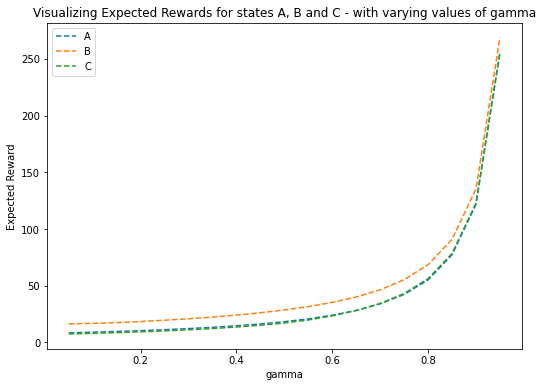

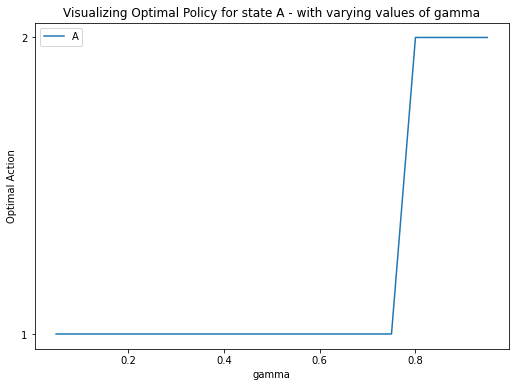

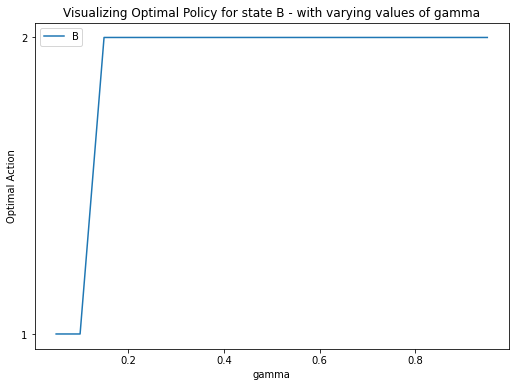

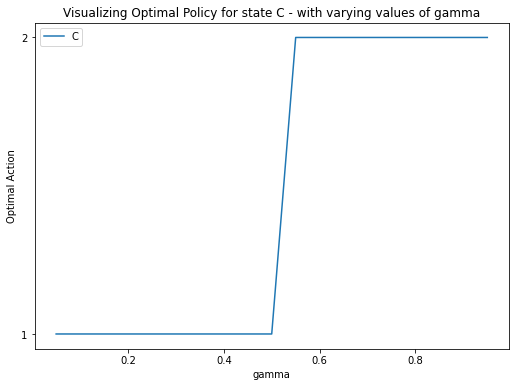

In [117]:
## Visualize policy iteration with multiple values of gamma
import matplotlib.pyplot as plt

policy_iteration_results, extra_info = run_policy_iteration(env)
state_space = list(policy_iteration_results[0.05]['Expected Reward'].keys())
gamma_vals = np.sort(list(policy_iteration_results.keys()))
state_wise_reward = {}
state_wise_action = {}
for st in state_space:
  state_wise_reward[st] = []
  state_wise_action[st] = []
  for gamma in policy_iteration_results:
    state_wise_reward[st].append(policy_iteration_results[gamma]['Expected Reward'][st])
    state_wise_action[st].append(policy_iteration_results[gamma]['Policy'][st])

plt.figure(figsize=(8.5,6))
plt.title("Visualizing Expected Rewards for states A, B and C - with varying values of gamma")
for st in state_space:
  plt.plot(gamma_vals,state_wise_reward[st],'--',label = st)
plt.legend(loc = 'best')
plt.xlabel("gamma")
plt.ylabel("Expected Reward")

for st in state_space:
  plt.figure(figsize=(8.5,6))
  plt.title("Visualizing Optimal Policy for state "+st+" - with varying values of gamma")
  plt.plot(gamma_vals,state_wise_action[st],label = st)
  plt.legend(loc = 'best')
  plt.xlabel("gamma")
  plt.ylabel("Optimal Action")


# Subjective questions


## 1.a How are values of $\gamma$ affecting results of policy iteration

Modify this cell/add code for your answer.

In [118]:
print("Expected Reward and Optimal Policy after Value Iteration with multiple values of gamma")
pd.set_option('display.max_colwidth', None)
pd.DataFrame(policy_iteration_results).T

Expected Reward and Optimal Policy after Value Iteration with multiple values of gamma


Expected Reward                          Policy
0.05    {'A': 8.511527294182539, 'B': 16.400259908653545, 'C': 7.498869066334438}  {'A': '1', 'B': '1', 'C': '1'}
0.10    {'A': 9.076506148654659, 'B': 16.856368562663413, 'C': 8.050865123013633}  {'A': '1', 'B': '1', 'C': '1'}
0.15      {'A': 9.708121492773689, 'B': 17.46450304225433, 'C': 8.66916045381265}  {'A': '1', 'B': '2', 'C': '1'}
0.20      {'A': 10.437030073770368, 'B': 18.482142855718322, 'C': 9.384398494823}  {'A': '1', 'B': '2', 'C': '1'}
0.25   {'A': 11.274074071593612, 'B': 19.62962962714457, 'C': 10.207407404926943}  {'A': '1', 'B': '2', 'C': '1'}
0.30   {'A': 12.243837242514767, 'B': 20.93406593274288, 'C': 11.162756161433684}  {'A': '1', 'B': '2', 'C': '1'}
0.35   {'A': 13.37871443314124, 'B': 22.430769227661276, 'C': 12.282824022182337}  {'A': '1', 'B': '2', 'C': '1'}
0.40   {'A': 14.722222218890456, 'B': 24.16666666333477, 'C': 13.611111107779344}  {'A': '1', 'B': '2', 'C': '1'}
0.45    {'A': 16.334131264623938, 'B': 26.2055335916294, 'C': 15.207370701243658}  {'A': '1', 'B': '2', 'C': '1'}
0.50  {'A': 18.298701292975394, 'B': 28.636363630637724, 'C': 17.155844150118252}  {'A': '1', 'B': '2', 'C': '1'}
0.55  {'A': 20.789988631690285, 'B': 31.607396693357217, 'C': 19.830725208961304}  {'A': '1', 'B': '2', 'C': '2'}
0.60   {'A': 24.025686435735523, 'B': 35.32772363679841, 'C': 23.458813096497263}  {'A': '1', 'B': '2', 'C': '2'}
0.65     {'A': 28.276692058262245, 'B': 40.0962805733634, 'C': 28.12997877956433}  {'A': '1', 'B': '2', 'C': '2'}
0.70    {'A': 34.06193076352557, 'B': 46.435416151978885, 'C': 34.36604100348755}  {'A': '1', 'B': '2', 'C': '2'}
0.75    {'A': 42.31741137421433, 'B': 55.285053901178884, 'C': 43.10631738345932}  {'A': '1', 'B': '2', 'C': '2'}
0.80     {'A': 55.0793650415215, 'B': 68.55820102035747, 'C': 56.269841231997695}  {'A': '2', 'B': '2', 'C': '2'}
0.85     {'A': 77.24651208813728, 'B': 90.81170060881541, 'C': 78.43345570831532}  {'A': '2', 'B': '2', 'C': '2'}
0.90   {'A': 121.65347103938102, 'B': 135.3062754397477, 'C': 122.83690299204375}  {'A': '2', 'B': '2', 'C': '2'}
0.95   {'A': 255.0229082403122, 'B': 268.76461831792886, 'C': 256.20284924326205}  {'A': '2', 'B': '2', 'C': '2'}

From the above code and plots of visualization of policy iteration for different values of gamma, the following observations can be made:
- The total expected reward increases for all three states - A, B and C, when gamma is increased from 0.05 to 0.95. This is an expected result because when the probability of break down of vehicle (1-gamma) decreases, the expected reward increases.
- For higher values of gamma, the optimal action for each state - A, B and C, tends to being action 2 - which is going to the nearest taxi stand and wait in line. On the other hand, for lower values of gamma, action 1 - cruising the streets is more optimal in most cases for all three states (for state B, action 1 is optimal only when gamma = 0.05 and 0.10).

## 1.b For modified policy itetaration, do you find any improvement if you choose m=10.

Explain your answer

In [119]:
mod_policy_iteration_results, extra_info = run_modified_policy_iteration(env)
pd.set_option('display.max_colwidth', None)
pd.DataFrame(mod_policy_iteration_results).T

Expected Reward                          Policy
1                  {'A': 25.675390625, 'B': 39.27046874999999, 'C': 26.9415625}  {'A': '2', 'B': '2', 'C': '2'}
2    {'A': 48.55490468521119, 'B': 62.203121287078865, 'C': 49.737400154724135}  {'A': '2', 'B': '2', 'C': '2'}
3       {'A': 66.5070336319201, 'B': 80.16002669080505, 'C': 67.69034691854696}  {'A': '2', 'B': '2', 'C': '2'}
4      {'A': 79.80001035898594, 'B': 93.45288211402925, 'C': 80.98345265619488}  {'A': '2', 'B': '2', 'C': '2'}
5     {'A': 89.81178760453517, 'B': 103.46459982778873, 'C': 90.99521888644551}  {'A': '2', 'B': '2', 'C': '2'}
6       {'A': 97.34789594613352, 'B': 111.0007013724186, 'C': 98.5313279386138}  {'A': '2', 'B': '2', 'C': '2'}
7   {'A': 103.04102709136063, 'B': 116.69383160589359, 'C': 104.22445904173425}  {'A': '2', 'B': '2', 'C': '2'}
8   {'A': 107.35314857748017, 'B': 121.00595299110296, 'C': 108.53658053027281}  {'A': '2', 'B': '2', 'C': '2'}
9   {'A': 110.62884446690502, 'B': 124.28164886875567, 'C': 111.81227641956042}  {'A': '2', 'B': '2', 'C': '2'}
10   {'A': 113.12458909097927, 'B': 126.77739349151406, 'C': 114.3080210436424}  {'A': '2', 'B': '2', 'C': '2'}
11   {'A': 115.03191631274339, 'B': 128.68472071312897, 'C': 116.2153482654061}  {'A': '2', 'B': '2', 'C': '2'}
12    {'A': 116.49414072619648, 'B': 130.1469451265653, 'C': 117.6775726788592}  {'A': '2', 'B': '2', 'C': '2'}
13  {'A': 117.61874705064764, 'B': 131.27155145101457, 'C': 118.80217900331036}  {'A': '2', 'B': '2', 'C': '2'}
14  {'A': 118.48653594228573, 'B': 132.13934034265242, 'C': 119.66996789494846}  {'A': '2', 'B': '2', 'C': '2'}

From the above table, we can notice that the rewards for all states increases with $m$. Hence, when $m=10$, rewards increase to a higher value compared to the case when $m=9$. However, the optimal policy remains the same irrespective of $m$ value. 

## 1.c Compare and contrast the behavior of Value Iteration and Gauss Seidel Value Iteraton

Add code/markdown as required

In [124]:
print("Value Iteration")
value_iteration_results, extra_info = run_value_iteration(env)
pd.set_option('display.max_colwidth', None)
pd.DataFrame(value_iteration_results).T

Value Iteration


Expected Reward                          Policy
0.05    {'A': 8.511527294182539, 'B': 16.400259908653545, 'C': 7.498869066334438}  {'A': '1', 'B': '1', 'C': '1'}
0.10    {'A': 9.076506148654659, 'B': 16.856368562663413, 'C': 8.050865123013633}  {'A': '1', 'B': '1', 'C': '1'}
0.15     {'A': 9.708121491779233, 'B': 17.46450304126533, 'C': 8.669160452818193}  {'A': '1', 'B': '2', 'C': '1'}
0.20    {'A': 10.43703007317419, 'B': 18.482142855128945, 'C': 9.384398494226822}  {'A': '1', 'B': '2', 'C': '1'}
0.25  {'A': 11.274074070814656, 'B': 19.629629626369894, 'C': 10.207407404147988}  {'A': '1', 'B': '2', 'C': '1'}
0.30  {'A': 12.243837242020097, 'B': 20.934065932248725, 'C': 11.162756160939015}  {'A': '1', 'B': '2', 'C': '1'}
0.35   {'A': 13.378714431634197, 'B': 22.43076922615468, 'C': 12.282824020675294}  {'A': '1', 'B': '2', 'C': '1'}
0.40   {'A': 14.722222216827301, 'B': 24.16666666127172, 'C': 13.611111105716189}  {'A': '1', 'B': '2', 'C': '1'}
0.45    {'A': 16.33413126569031, 'B': 26.20553359269582, 'C': 15.207370702310026}  {'A': '1', 'B': '2', 'C': '1'}
0.50   {'A': 18.298701293190973, 'B': 28.636363630853307, 'C': 17.15584415033383}  {'A': '1', 'B': '2', 'C': '1'}
0.55  {'A': 20.789988627490125, 'B': 31.607396689157056, 'C': 19.830725204761144}  {'A': '1', 'B': '2', 'C': '2'}
0.60    {'A': 24.02568643325821, 'B': 35.327723634321096, 'C': 23.45881309401995}  {'A': '1', 'B': '2', 'C': '2'}
0.65    {'A': 28.276692058162972, 'B': 40.09628057326413, 'C': 28.12997877946505}  {'A': '1', 'B': '2', 'C': '2'}
0.70     {'A': 34.06193076174113, 'B': 46.43541615019445, 'C': 34.36604100170312}  {'A': '1', 'B': '2', 'C': '2'}
0.75   {'A': 42.317411373067756, 'B': 55.28505390003232, 'C': 43.106317382312746}  {'A': '1', 'B': '2', 'C': '2'}
0.80     {'A': 55.07936504724612, 'B': 68.55820102608209, 'C': 56.26984123772232}  {'A': '2', 'B': '2', 'C': '2'}
0.85     {'A': 77.24651209325512, 'B': 90.81170061393325, 'C': 78.43345571343316}  {'A': '2', 'B': '2', 'C': '2'}
0.90  {'A': 121.65347103895924, 'B': 135.30627543932593, 'C': 122.83690299162194}  {'A': '2', 'B': '2', 'C': '2'}
0.95   {'A': 255.02290824365164, 'B': 268.76461832126836, 'C': 256.2028492466015}  {'A': '2', 'B': '2', 'C': '2'}

In [125]:
print("Gauss Seidel Value Iteration")
gs_value_iteration_results, extra_info = run_gauss_seidel_value_iteration(env)
pd.set_option('display.max_colwidth', None)
pd.DataFrame(gs_value_iteration_results).T

Gauss Seidel Value Iteration


Expected Reward                          Policy
0.05   {'A': 8.511527294546923, 'B': 16.400259909029575, 'C': 7.4988690667106095}  {'A': '1', 'B': '1', 'C': '1'}
0.10     {'A': 9.076506149392834, 'B': 16.85636856362452, 'C': 8.050865123980312}  {'A': '1', 'B': '1', 'C': '1'}
0.15      {'A': 9.70812149293256, 'B': 17.464503042356245, 'C': 8.66916045411395}  {'A': '1', 'B': '2', 'C': '1'}
0.20     {'A': 10.43703007363936, 'B': 18.48214285510763, 'C': 9.384398495833036}  {'A': '1', 'B': '2', 'C': '1'}
0.25   {'A': 11.274074072135488, 'B': 19.62962962714145, 'C': 10.207407406785403}  {'A': '1', 'B': '2', 'C': '1'}
0.30  {'A': 12.243837240938772, 'B': 20.934065930435885, 'C': 11.162756161665108}  {'A': '1', 'B': '2', 'C': '1'}
0.35      {'A': 13.3787144345583, 'B': 22.43076922870161, 'C': 12.28282402456309}  {'A': '1', 'B': '2', 'C': '1'}
0.40  {'A': 14.722222217898851, 'B': 24.166666661495807, 'C': 13.611111109029693}  {'A': '1', 'B': '2', 'C': '1'}
0.45    {'A': 16.33413126434644, 'B': 26.20553359041331, 'C': 15.207370703537933}  {'A': '1', 'B': '2', 'C': '1'}
0.50   {'A': 18.298701293837997, 'B': 28.63636363077955, 'C': 17.155844153026397}  {'A': '1', 'B': '2', 'C': '1'}
0.55    {'A': 20.78998863222275, 'B': 31.60739669290458, 'C': 19.830725212339292}  {'A': '1', 'B': '2', 'C': '2'}
0.60    {'A': 24.02568643692515, 'B': 35.32772363671855, 'C': 23.458813101474426}  {'A': '1', 'B': '2', 'C': '2'}
0.65   {'A': 28.276692061545695, 'B': 40.09628057546244, 'C': 28.129978786496867}  {'A': '1', 'B': '2', 'C': '2'}
0.70     {'A': 34.06193076743594, 'B': 46.43541615465501, 'C': 34.36604101132381}  {'A': '1', 'B': '2', 'C': '2'}
0.75     {'A': 42.31741137784243, 'B': 55.28505390328474, 'C': 43.10631739208525}  {'A': '1', 'B': '2', 'C': '2'}
0.80     {'A': 55.079365051578144, 'B': 68.5582010300939, 'C': 56.26984124730355}  {'A': '2', 'B': '2', 'C': '2'}
0.85     {'A': 77.24651209951202, 'B': 90.81170061982581, 'C': 78.43345572578708}  {'A': '2', 'B': '2', 'C': '2'}
0.90  {'A': 121.65347104963263, 'B': 135.30627544959796, 'C': 122.83690300915262}  {'A': '2', 'B': '2', 'C': '2'}
0.95    {'A': 255.0229082673451, 'B': 268.7646183445272, 'C': 256.20284927787594}  {'A': '2', 'B': '2', 'C': '2'}

From the above tables, it can be noticed that the results of value iteration and Gauss-Seidel Value Iteration exactly match - both expected rewards and optimal policy, for all states. This is expected because the Gauss Seidel variant of Value Iteration is very similar to the original variant, but considers updated values for calculating the reward. This does not lead to change in the results, but helps in faster convergence.

# Submit to AIcrowd 🚀

In [ ]:
!DATASET_PATH=$AICROWD_DATASET_PATH aicrowd notebook submit -c iit-m-rl-assignment-2-taxi -a assets

No jupyter lab module found. Using jupyter notebook.
Using notebook: /content/Copy%20of%20IITM_Assignment_2_Taxi_Release.ipynb for submission...
Mounting Google Drive 💾
Your Google Drive will be mounted to access the colab notebook
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
